In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
Num_proyec=100 #Numero de proyecciones que se usaran
Num_Angulos=Num_proyec+2
Angulos= np.linspace(-10,10,Num_Angulos) #lo normal es que sea entre -10 y 10 grados

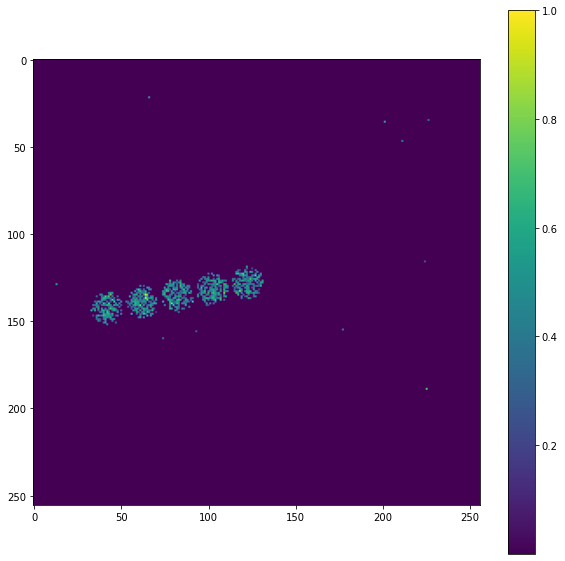

In [3]:
ct_scans = sitk.GetArrayFromImage(sitk.ReadImage('MyOutputFile0-Dose.mhd', sitk.sitkFloat32))
imagen_GATE_dosis = ct_scans[0]+0.00000000001
ct_scansBase = sitk.GetArrayFromImage(sitk.ReadImage('MyOutputFileBase-Dose.mhd' , sitk.sitkFloat32))
imagen_GATE_dosisBase = ct_scansBase[0]

imagen_GATE_dosis= imagen_GATE_dosisBase/imagen_GATE_dosis
imagen_GATE_dosis= imagen_GATE_dosis/np.max(imagen_GATE_dosis)
#imagen_GATE_dosis= imagen_GATE_dosisBase
#imagen_GATE_dosis= imagen_GATE_dosis<1

fig = plt.figure(figsize=(10,10))
plt.imshow(imagen_GATE_dosis,cmap='viridis')
plt.colorbar()

In [4]:
from skimage.transform import radon, iradon

tamano_rodaja = 1 # en pixeles
tamano_detector = 256 # en pixeles
max_ind = int((tamano_detector/tamano_rodaja) - 1) # Numero de rodajas (enteras)
numero_imagenes = Num_proyec

IMGs = []

for i in range(numero_imagenes):
    #IMG = np.genfromtxt('outfile%d.txt' %i)
    IMG = pd.read_csv('outfile%d.txt' %i,sep=',',header=None)
    IMG = pd.DataFrame(IMG)
    #print(IMG)
    IMGs.append(IMG)

IMGs = np.array(IMGs)

In [5]:
sinograms = []

for ind in range(max_ind):
    projections = []
    for im in IMGs:
        rodaja = np.sum(im[tamano_rodaja*ind:tamano_rodaja*(ind+1), :], axis=0)
        projections.append(rodaja)
    
    projections = np.array(projections)
    sinograms.append(np.transpose(projections))

sinograms = np.array(sinograms)

del projections

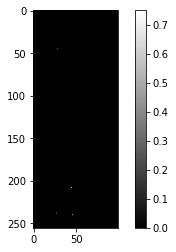

In [6]:
plt.imshow(sinograms[0],cmap="gray")
plt.colorbar()

In [7]:
print(len(Angulos))
#numero_imagenes
print(numero_imagenes)

102
100


0.0015736886328355682


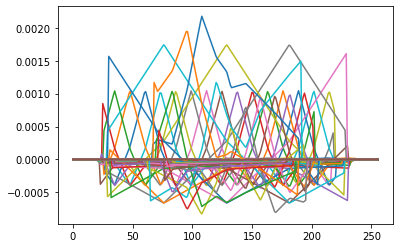

In [10]:
#Angulos= np.delete(Angulos,-1)
theta= np.delete(Angulos,[-1,-2])
reconstruction_fbp= iradon(sinograms[0],theta=theta,filter_name='hann')
print(max(reconstruction_fbp[100]))
plt.plot(reconstruction_fbp)
plt.show()

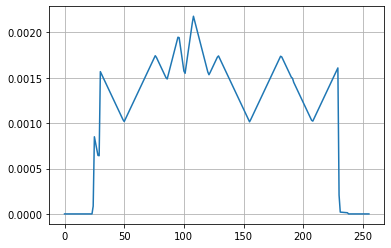

In [26]:
k=[]
for i in reconstruction_fbp:
    k.append(max(i))
plt.plot(k)
plt.grid()

In [27]:
#theta = np.linspace(0.0, 208.8, numero_imagenes, endpoint=False)
#theta= Angulos
rodajas = []

for ind, sinogram in enumerate(sinograms):
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann')
    plt.imshow(reconstruction_fbp, cmap="gray", vmin=0.02, vmax=0.04)
    plt.colorbar()
    plt.savefig("rodaja_{}.png".format(ind))
    plt.clf()
    
    indx_sup = np.where(reconstruction_fbp >= 0.003)
    indx_inf = np.where(reconstruction_fbp <= 0.0005)
    reconstruction_fbp[indx_sup[0], indx_sup[1]] = 0.003
    reconstruction_fbp[indx_inf[0], indx_inf[1]] = 0.0005
    rodajas.append(reconstruction_fbp)

<Figure size 432x288 with 0 Axes>

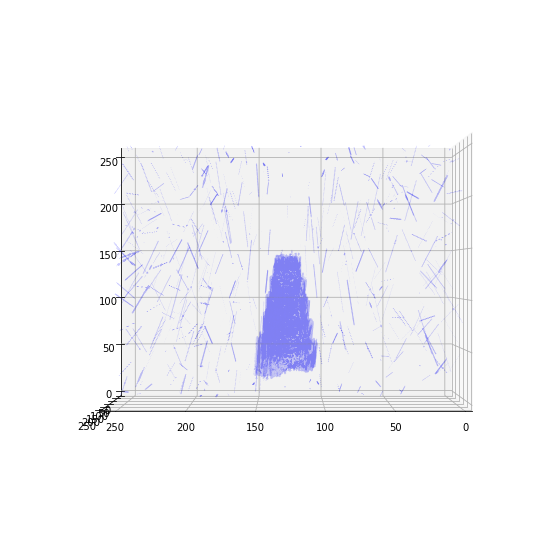

In [29]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
%matplotlib inline

def plot_3d(image, threshold=0.001): 
    verts, faces, normals, values = measure.marching_cubes(image, level=threshold , method='lewiner')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.2) #alpha =0.1
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    ax.set_zlim(0, 255)
    ax.view_init(0,90) # (polar, azimutal) 
    plt.show()

rodajas = np.array(rodajas)
plot_3d(rodajas)